# Tutorial: explain a tabular classifier through LORE

LORE provides interpretable explanations for the decisions made by machine learning models, particularly in situations where it might be challenging to explain the model's behavior using traditional methods. LORE is designed to offer explanations on a per-instance basis, meaning it provides insights into why a specific prediction was made for a particular data point. This is in contrast to global explanations that aim to provide an overview of a model's behavior across the entire dataset.


In this tutorial we will explain the reasoning of a random forest classifier when applied to an instance of the Adult Income dataset ( https://archive.ics.uci.edu/dataset/2/adult). This dataset contains census data from 1994 census database, the classification problem associated to such data involves the prediction of the annual income of a person, given a set of socio-economic caracteristics: 
- working class
- marital status
- occupation
- relationship
- race
- sex
- capital gain/loss
- native country 





### Dataset loading 

Lore libray has a module devoted to dataset handling. Here we use TabularDataset class to load a dataset from a csv file. A TabularDataset has a column that represent the target class (`class_name`) of the classification task  object, and has two main attributes: 
- `df` : a pandas dataframe representing the tabular data
- `descriptor` : a dictionary containing internal data related to the dataset. It is build when a TabularDataset is created, but it could also be edited. It is used by the next steps of LORE methodology to distinguish among numerical, categorical, ordinal and target features of the dataset.

In [1]:
from lore_sa.dataset import TabularDataset
import pandas as pd

# Cargar el dataset y limpiar espacios en los nombres de columnas
df = pd.read_csv('test/resources/adult.csv')
df.columns = df.columns.str.strip()  # Elimina espacios en los nombres de las columnas

# Asegurar que cada clase tiene exactamente 5 muestras (o todas las que existan si hay menos de 5)
df_small = df.groupby("class", group_keys=False).apply(lambda x: x.sample(n=11, random_state=42)).reset_index(drop=True)

# Guardar el nuevo dataset reducido
df_small.to_csv('test/resources/adult_small.csv', index=False)

# adult.csv --> dataset completo
# adult_small.csv --> dataset reducido

dataset = TabularDataset.from_csv('test/resources/adult_small.csv', class_name="class")

# Mostrar la distribución de clases en el dataset reducido
print(dataset.df["class"].value_counts())


dataset.df  # Mostrar el dataset reducido


2025-03-28 10:06:37,908 numexpr.utils INFO     Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2025-03-28 10:06:37,908 numexpr.utils INFO     NumExpr defaulting to 8 threads.
C:\Users\pablo\AppData\Local\Temp\ipykernel_18960\2036078070.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_small = df.groupby("class", group_keys=False).apply(lambda x: x.sample(n=11, random_state=42)).reset_index(drop=True)
2025-03-28 10:06:38,280 root         INFO     test/resources/adult_small.csv file imported


class
>50K     11
<=50K     9
Name: count, dtype: int64


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,32,Private,43403,Some-college,10,Divorced,Farming-fishing,Not-in-family,White,Female,0,1590,54,United-States,<=50K
2,51,Private,332243,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Male,0,0,45,United-States,<=50K
3,27,Private,158156,HS-grad,9,Never-married,Other-service,Not-in-family,White,Female,0,0,42,United-States,<=50K
4,64,Self-emp-not-inc,170421,Some-college,10,Widowed,Craft-repair,Not-in-family,White,Female,0,0,8,United-States,<=50K
6,53,Private,152657,10th,6,Married-civ-spouse,Craft-repair,Husband,Black,Male,0,0,40,United-States,<=50K
7,50,Federal-gov,299831,Some-college,10,Divorced,Adm-clerical,Unmarried,White,Female,0,880,40,United-States,<=50K
8,38,Private,149419,Assoc-voc,11,Never-married,Tech-support,Not-in-family,White,Male,0,0,50,United-States,<=50K
9,34,Private,224358,10th,6,Never-married,Other-service,Unmarried,Black,Female,0,0,40,United-States,<=50K
10,39,Private,205359,Assoc-acdm,12,Widowed,Adm-clerical,Unmarried,White,Female,0,0,45,United-States,<=50K
11,38,Private,233194,HS-grad,9,Married-civ-spouse,Sales,Husband,Black,Male,0,0,40,United-States,>50K


The `TabularDataset` class does some data inspection and preparation when it is created starting from a text-based file. Each attribute of the data is analysed to derive type and internal statistics. The `descriptor` field is automatically updates with these information. In particular, the `descriptor` is a dictionary that contains the following keys:
- `numerical` : a dictionary containing the numerical features of the dataset and their statistics
- `categorical` : a dictionary containing the categorical features of the dataset and their statistics
- `ordinal` : (this is still not implemented) a dictionary containing the ordinal features of the dataset and their statistics
- `target` : the details of the target feature of the dataset and its statistics  

In [2]:
dataset.descriptor.keys()

dict_keys(['numeric', 'categorical', 'ordinal', 'target'])

Before proceeding with the explanation, let's do some data preprocessing by dropping a few attributes that are not relevant for the learning. 

We operate directly on the `df` attribute of the dataset, then we update the descriptor.


In [3]:
dataset.df.drop(['fnlwgt', 'education-num','capital-gain','capital-loss'], inplace=True, axis=1)
dataset.update_descriptor()

feature_names = list(dataset.descriptor["numeric"].keys()) + list(dataset.descriptor["categorical"].keys())
class_names = dataset.df["class"].unique().tolist()

dataset.df[:5]

,age,workclass,education,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,class
0,32,Private,Some-college,Divorced,Farming-fishing,Not-in-family,White,Female,54,United-States,<=50K
2,51,Private,Bachelors,Divorced,Prof-specialty,Not-in-family,White,Male,45,United-States,<=50K
3,27,Private,HS-grad,Never-married,Other-service,Not-in-family,White,Female,42,United-States,<=50K
4,64,Self-emp-not-inc,Some-college,Widowed,Craft-repair,Not-in-family,White,Female,8,United-States,<=50K
6,53,Private,10th,Married-civ-spouse,Craft-repair,Husband,Black,Male,40,United-States,<=50K


In [4]:
print(feature_names)
print(class_names)

['age', 'hours-per-week', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
['<=50K', '>50K']


## Model Learning

We start by training a Random Forest classifier on the Adult dataset. We will use the `df` attribute of the dataset, which is a pandas dataframe containing the tabular data. We will use the `class_name` attribute of the dataset to identify the target feature of the classification task. Since the data contains non-numeric attributes, we proceed with a preprocessing of the data to mange these attributes. We will exploit `Pipeline` class from `sklearn` to create a pipeline that applies one-hot encoding to the categorical features and label encoding to the target feature. 

In [5]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from lore_sa.bbox import sklearn_classifier_bbox
from sklearn.tree import DecisionTreeClassifier

# Extraer columnas del descriptor
numeric_features = list(dataset.descriptor["numeric"].keys())
categorical_features = list(dataset.descriptor["categorical"].keys())

# Función para obtener nombres de columnas transformadas
def get_feature_names_from_column_transformer(preprocessor):
    output_features = []

    for name, trans, cols in preprocessor.transformers_:
        if hasattr(trans, 'get_feature_names_out'):
            names = trans.get_feature_names_out()
            # Si devuelve algo como 'num__age', quita el prefijo
            names = [n.split('__')[-1] for n in names]
        else:
            names = cols
        output_features.extend(names)

    return output_features

# Función para entrenar modelo
def train_model(dataset):
    # Índices según posición en el DataFrame
    num_indices = [0, 8]  # 'age', 'hours-per-week'
    cat_indices = [1, 2, 3, 4, 5, 6, 9]  # resto de columnas

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), num_indices),
            ('cat', OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), cat_indices)
        ]
    )

    model = make_pipeline(preprocessor, DecisionTreeClassifier(max_depth=3, random_state=42))

    # Entrenamiento
    X = dataset.df.loc[:, 'age':'native-country'].values
    y = dataset.df['class'].values

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42, stratify=y
    )

    model.fit(X_train, y_train)
    feature_names = get_feature_names_from_column_transformer(preprocessor)

    return sklearn_classifier_bbox.sklearnBBox(model), X_train, y_train, X_test, y_test, feature_names


In [6]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.experimental import enable_halving_search_cv
from lore_sa.lore import TabularRandomGeneratorLore

bbox, X_train, y_train, X_test, y_test, _  = train_model(dataset)

# # Obtener predicciones en el conjunto de prueba
y_pred = bbox.bbox.predict(X_test)

# Imprimir métricas
print("🔍 Reporte de clasificación:\n")
print(classification_report(y_test, y_pred))
print(f" Precisión del modelo: {accuracy_score(y_test, y_pred):.2f}")

🔍 Reporte de clasificación:

              precision    recall  f1-score   support

       <=50K       1.00      0.25      0.40         4
        >50K       0.57      1.00      0.73         4

    accuracy                           0.62         8
   macro avg       0.79      0.62      0.56         8
weighted avg       0.79      0.62      0.56         8

 Precisión del modelo: 0.62


## Explanation

Given the blackbox model, we can now explain the reasoning behind the classification of a specific instance. We will use the `LORE` class to explain the classification of the first instance of the dataset. The `explain_instance` method of the `LORE` class takes as input the instance to be explained, the blackbox model, and the dataset. It returns an explanation object that contains the explanation of the classification of the instance.

The constructor of the explanator class takes as input the blackbox model and the dataset. The `dataset` instance is used to get the information from the descriptor. In case the trainin set is not available, the descriptor could be built from the test set or by the metadata of the dataset.

In [7]:
from lore_sa.lore import TabularRandomGeneratorLore
from lore_sa.lore import TabularGeneticGeneratorLore

tabularLore_small = TabularGeneticGeneratorLore(bbox, dataset)

# Elegir una instancia para explicar
num_row = 5  # Puedes cambiar el índice para probar distintas instancias
x = dataset.df.iloc[num_row][:-1]

# Generar explicación
explanation_small = tabularLore_small.explain(x)

gen	nevals	avg     	min     	max     	std        
0  	500   	0.993307	0.993307	0.993307	1.11022e-16
1  	263   	0.982415	0.497537	0.993307	0.0724239  
2  	299   	0.974501	0.49751 	0.993307	0.0943749  
3  	276   	0.978481	0.499623	0.993307	0.0841544  
4  	302   	0.978457	0.49891 	0.993307	0.0841791  
5  	308   	0.981415	0.498598	0.993307	0.075521   
6  	303   	0.981414	0.496667	0.993307	0.0755415  
7  	320   	0.976463	0.496361	0.993307	0.0894506  
8  	303   	0.979443	0.493978	0.993307	0.0814548  
9  	313   	0.983407	0.49727 	0.993307	0.0691029  
10 	284   	0.975479	0.497757	0.993307	0.0919311  
11 	287   	0.976473	0.491075	0.993307	0.0895456  
12 	300   	0.978441	0.49699 	0.993307	0.0842024  
13 	298   	0.9834  	0.498834	0.993307	0.0690803  
14 	310   	0.975487	0.49737 	0.993307	0.091963   
15 	296   	0.979441	0.499857	0.993307	0.0813772  
16 	280   	0.984374	0.499752	0.993307	0.0655874  
17 	303   	0.98241 	0.497774	0.993307	0.0724141  
18 	296   	0.980427	0.499477	0.993307	0.0785026  


In [8]:
from IPython.display import Image
import numpy as np

def visualize_supertree(tree, feature_names=None, class_names=None):
    from graphviz import Digraph
    import re

    dot = Digraph()
    node_id = [0]

    def base_name(feat):
        # Si es de tipo "occupation=Sales" → devuelve "occupation"
        return feat.split('=')[0] if '=' in feat else feat

    def add_node(node, parent_id=None, edge_label=''):
        curr_id = str(node_id[0])
        node_id[0] += 1

        if node.is_leaf:
            class_index = np.argmax(node.labels)
            class_label = class_names[class_index] if class_names else f"class {class_index}"
            label = f"class: {class_label}\n{node.labels}"
        else:
            # Nombre del atributo (ya en texto plano)
            try:
                fname = feature_names[node.feat]
                label = base_name(fname)
            except:
                label = f"X_{node.feat}"

        dot.node(curr_id, label)

        if parent_id is not None:
            dot.edge(parent_id, curr_id, label=edge_label)

        if not node.is_leaf:
            for i, child in enumerate(node.children):
                try:
                    feat_val = feature_names[node.feat]
                except:
                    feat_val = f"X_{node.feat}"

                # Si categórico (hay =) → mostrar comparación clara
                if '=' in feat_val:
                    attr, val = feat_val.split('=')
                    if i == 0:
                        edge = f"≠ {val}"  # izquierda
                    else:
                        edge = f"= {val}"  # derecha
                else:
                    # Numérica
                    if i == 0:
                        edge = f"<= {node.intervals[i]:.2f}"
                    else:
                        edge = f"> {node.intervals[i - 1]:.2f}"

                add_node(child, curr_id, edge)

    add_node(tree)
    return dot

2025-03-28 10:07:28,083 matplotlib   DEBUG    matplotlib data path: c:\Users\pablo\anaconda3\Lib\site-packages\matplotlib\mpl-data
2025-03-28 10:07:28,084 matplotlib   DEBUG    CONFIGDIR=C:\Users\pablo\.matplotlib
2025-03-28 10:07:28,283 matplotlib   DEBUG    interactive is False
2025-03-28 10:07:28,283 matplotlib   DEBUG    platform is win32
2025-03-28 10:07:28,382 matplotlib   DEBUG    CACHEDIR=C:\Users\pablo\.matplotlib
2025-03-28 10:07:28,383 matplotlib.font_manager DEBUG    Using fontManager instance from C:\Users\pablo\.matplotlib\fontlist-v390.json
2025-03-28 10:07:28,938 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-03-28 10:07:28,938 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-03-28 10:07:28,954 matplotlib.font_manager DEBUG    findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2025-03-28 10:07:28,954 matplotl

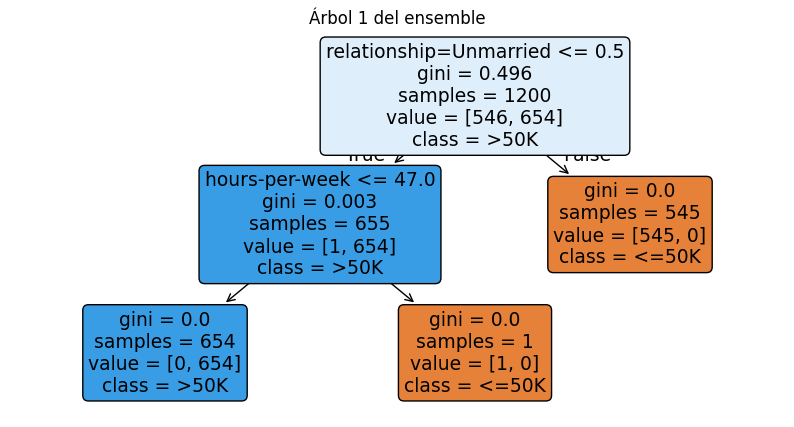

2025-03-28 10:07:30,545 matplotlib.font_manager DEBUG    findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=11.046289211935731.
2025-03-28 10:07:30,545 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='c:\\Users\\pablo\\anaconda3\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansMono-Oblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2025-03-28 10:07:30,546 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='c:\\Users\\pablo\\anaconda3\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXNonUniIta.ttf', name='STIXNonUnicode', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2025-03-28 10:07:30,546 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='c:\\Users\\pablo\\anaconda3\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizTwoSymReg.ttf', name='STIX

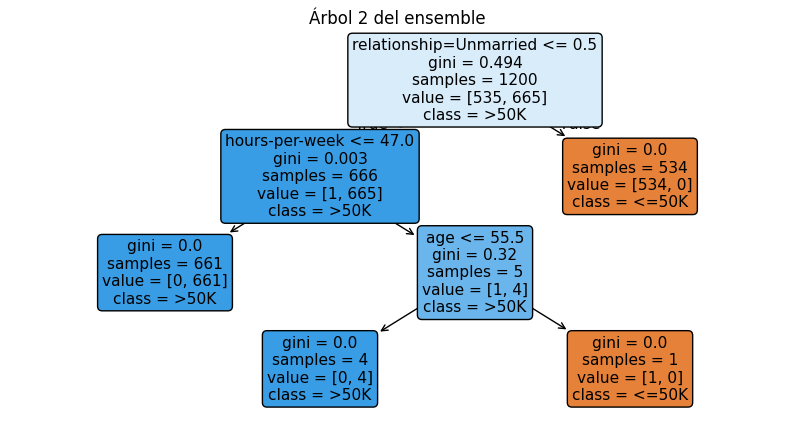

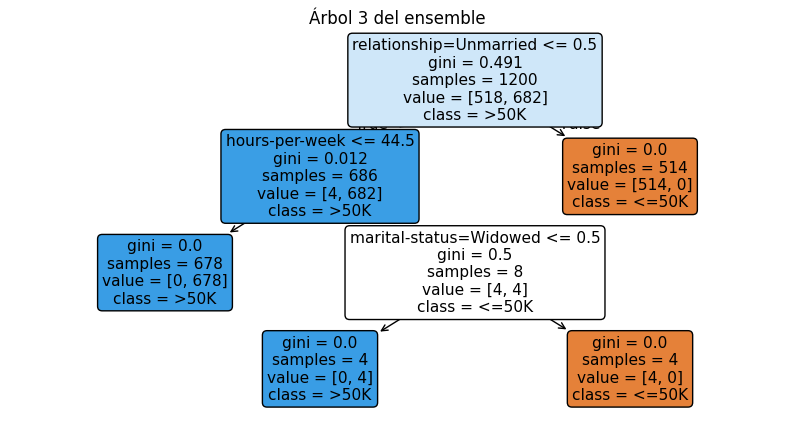

2025-03-28 10:07:31,599 matplotlib.font_manager DEBUG    findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=16.915241906147685.
2025-03-28 10:07:31,599 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='c:\\Users\\pablo\\anaconda3\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansMono-Oblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2025-03-28 10:07:31,601 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='c:\\Users\\pablo\\anaconda3\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXNonUniIta.ttf', name='STIXNonUnicode', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2025-03-28 10:07:31,601 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='c:\\Users\\pablo\\anaconda3\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizTwoSymReg.ttf', name='STIX

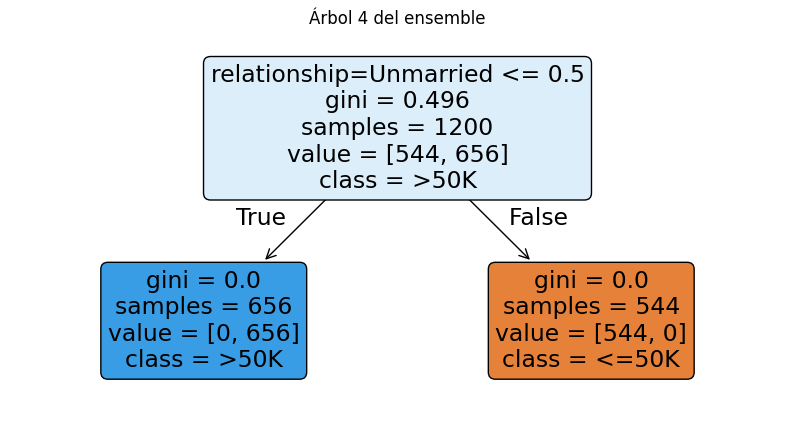

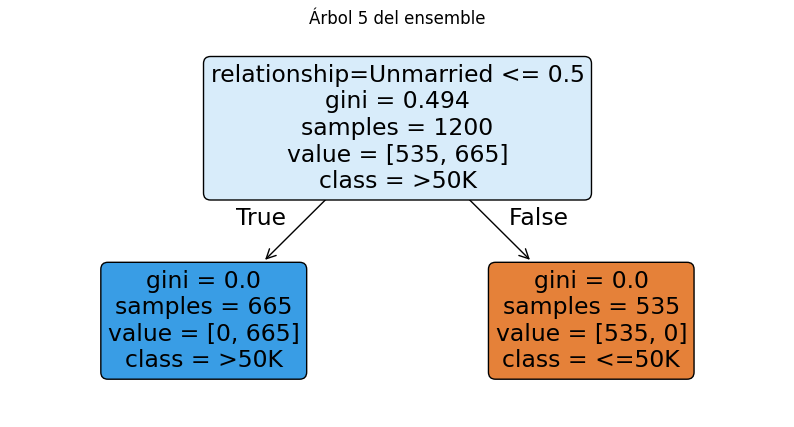

In [9]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

ensemble = tabularLore_small.surrogate  # ya está entrenado internamente
feature_names = list(tabularLore_small.encoder.encoded_features.values())

# Dibujar cada árbol individual
for i, tree in enumerate(ensemble.trees):
    plt.figure(figsize=(10, 5))
    plot_tree(tree, filled=True, rounded=True, 
              feature_names=feature_names, 
              class_names=class_names)
    plt.title(f"Árbol {i+1} del ensemble")
    plt.show()

2025-03-28 10:07:32,479 graphviz._tools DEBUG    deprecate positional args: graphviz.backend.piping.pipe(['renderer', 'formatter', 'neato_no_op', 'quiet'])
2025-03-28 10:07:32,482 graphviz._tools DEBUG    deprecate positional args: graphviz.backend.rendering.render(['renderer', 'formatter', 'neato_no_op', 'quiet'])
2025-03-28 10:07:32,484 graphviz._tools DEBUG    deprecate positional args: graphviz.backend.unflattening.unflatten(['stagger', 'fanout', 'chain', 'encoding'])
2025-03-28 10:07:32,487 graphviz._tools DEBUG    deprecate positional args: graphviz.backend.viewing.view(['quiet'])
2025-03-28 10:07:32,492 graphviz._tools DEBUG    deprecate positional args: graphviz.quoting.quote(['is_html_string', 'is_valid_id', 'dot_keywords', 'endswith_odd_number_of_backslashes', 'escape_unescaped_quotes'])
2025-03-28 10:07:32,494 graphviz._tools DEBUG    deprecate positional args: graphviz.quoting.a_list(['kwargs', 'attributes'])
2025-03-28 10:07:32,494 graphviz._tools DEBUG    deprecate positi

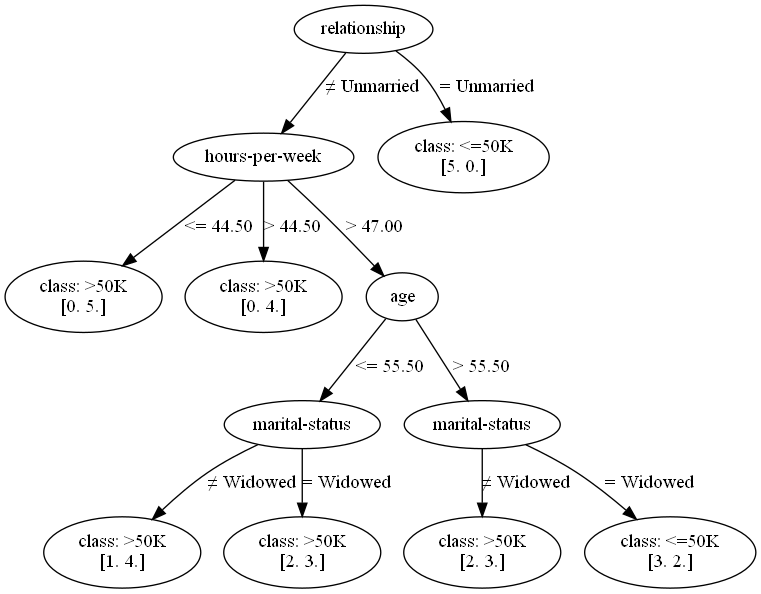

In [10]:
# Guardar también el árbol sin podar
from lore_sa.surrogate.decision_tree import SuperTree


ensemble = tabularLore_small.surrogate  # ya está entrenado internamente
unpruned_tree = SuperTree()
roots = [unpruned_tree.rec_buildTree(tree, list(range(tree.n_features_in_))) for tree in ensemble.trees]
unpruned_tree.mergeDecisionTrees(roots, num_classes=ensemble.trees[0].n_classes_)

feature_names = list(tabularLore_small.encoder.encoded_features.values())

# Guardar dentro de explanation_small
explanation_small["unpruned_tree"] = unpruned_tree

visualize_supertree(
    explanation_small["unpruned_tree"].root,
    feature_names=feature_names,
    class_names=class_names
).render('supertree_unpruned', format='png', cleanup=True)

Image(filename='supertree_unpruned.png')


2025-03-28 10:07:32,633 graphviz.saving DEBUG    write lines to 'supertree'
2025-03-28 10:07:32,633 graphviz.backend.execute DEBUG    run [WindowsPath('dot'), '-Kdot', '-Tpng', '-O', 'supertree']
2025-03-28 10:07:32,709 graphviz.rendering DEBUG    delete 'supertree'


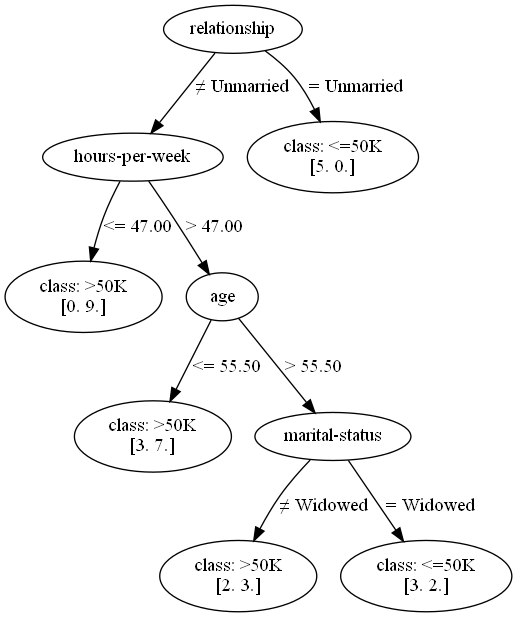

In [11]:
feature_names = list(tabularLore_small.encoder.encoded_features.values())

merged = explanation_small["merged_tree"]
visualize_supertree(merged.root, feature_names=feature_names, class_names=class_names).render('supertree', format='png', cleanup=True)

Image(filename='supertree.png')


In [96]:
x = dataset.df.iloc[num_row][:-1] # we exclude the target feature
print(x)

y = dataset.df.iloc[num_row][-1]
print(y)

age                          50
workclass           Federal-gov
education          Some-college
marital-status         Divorced
occupation         Adm-clerical
relationship          Unmarried
race                      White
sex                      Female
hours-per-week               40
native-country    United-States
Name: 7, dtype: object
<=50K


Comprobamos que se cumplen las reglas para la instancia que queremos explicar.

In [97]:
def check_rule_validity_v2(X, y, explanation, dataset_name="Train", decimals=1):
    """
    Comprueba cuántas instancias cumplen la regla generada por LORE,
    mostrando la regla principal antes de la evaluación.
    """
    rule = explanation['rule']
    conditions = rule['premises']
    target_class = rule['consequence']['val']

    print(f"\n{'='*70}")
    print(f"✅ Condiciones necesarias para que la instancia sea clasificada como '{target_class}':")
    for cond in conditions:
        attr, op, val = cond['attr'], cond['op'], cond['val']
        if isinstance(val, (int, float)):  # Solo redondear si es un número
            val = round(val, decimals)
        print(f"  - {attr} {op} {val}")

    print(f"\n{'='*70}")
    print(f"✅ Comprobando regla para la clase '{target_class}' en el {dataset_name}...")
    print(f"{'='*70}")

    valid_instances = []
    incorrect_classifications = 0  

    indices_clase_objetivo = [i for i in range(len(y)) if y[i] == target_class]

    if not indices_clase_objetivo:
        print(f"🚫 No hay instancias de la clase '{target_class}' en {dataset_name}.")
        return  # No hay instancias de esta clase, terminamos la función.

    for i in indices_clase_objetivo:
        cumple_todas = True
        print(f"\n🔎 Instancia {i}: {X[i]} - Clase real: {y[i]}")

        for cond in conditions:
            attr, op, val = cond['attr'], cond['op'], cond['val']
            if isinstance(val, (int, float)):  # Solo redondear si es un número
                val = round(val, decimals)
            
            col_index = list(dataset.df.columns).index(attr)
            instancia_val = X[i, col_index]  # NO aplicamos round() a cadenas

            cumple = False
            if isinstance(instancia_val, (int, float)):  # Solo comparar numéricos
                if op == ">":
                    cumple = instancia_val > val
                elif op == "<":
                    cumple = instancia_val < val
                elif op == ">=":
                    cumple = instancia_val >= val
                elif op == "<=":
                    cumple = instancia_val <= val
                elif op == "!=":
                    cumple = instancia_val != val
                elif op == "=":
                    cumple = instancia_val == val
            else:  # Si el valor es texto, solo comparar con '=' o '!='
                if op == "=":
                    cumple = instancia_val == val
                elif op == "!=":
                    cumple = instancia_val != val

            print(f"   - {attr} {op} {val} → Valor en la instancia: {instancia_val} {'✅' if cumple else '❌'}")
            cumple_todas &= cumple

        if cumple_todas:
            valid_instances.append(i)
        else:
            incorrect_classifications += 1

    # Resultados finales
    print(f"\n🔍 {len(valid_instances)} de {len(indices_clase_objetivo)} instancias de '{target_class}' cumplen la regla completamente.")
    print(f"✅ {len(valid_instances)} realmente son '{target_class}'.")
    print(f"❌ {incorrect_classifications} fueron clasificadas incorrectamente.")
    print(f"{'='*70}")

# 📌 Validar la regla en entrenamiento y test
check_rule_validity_v2(X_train, y_train, explanation_small, dataset_name="Train")
check_rule_validity_v2(X_test, y_test, explanation_small, dataset_name="Test")



✅ Condiciones necesarias para que la instancia sea clasificada como '>50K':
  - marital-status != Divorced
  - marital-status != Widowed
  - age > 37.0

✅ Comprobando regla para la clase '>50K' en el Train...

🔎 Instancia 0: [38 'Private' 'Bachelors' 'Married-civ-spouse' 'Exec-managerial' 'Husband'
 'White' 'Male' 55 'United-States'] - Clase real: >50K
   - marital-status != Divorced → Valor en la instancia: Married-civ-spouse ✅
   - marital-status != Widowed → Valor en la instancia: Married-civ-spouse ✅
   - age > 37.0 → Valor en la instancia: 38 ✅

🔎 Instancia 3: [42 'Private' 'Some-college' 'Never-married' 'Exec-managerial'
 'Not-in-family' 'White' 'Female' 40 'United-States'] - Clase real: >50K
   - marital-status != Divorced → Valor en la instancia: Never-married ✅
   - marital-status != Widowed → Valor en la instancia: Never-married ✅
   - age > 37.0 → Valor en la instancia: 42 ✅

🔎 Instancia 4: [46 'Private' 'Masters' 'Married-civ-spouse' 'Prof-specialty' 'Wife'
 'White' 'Femal

In [98]:
def check_counterfactuals(X, y, explanation, dataset_name="Train", decimals=1):
    """
    Evalúa los contrafactuales en un dataset (Train/Test) para verificar cuántas instancias reales cumplen sus condiciones.
    """
    counterfactuals = explanation['counterfactuals']

    print(f"\n{'='*70}")
    print(f"🔄 Comprobando CONTRAFACTUALES en el dataset {dataset_name}...")
    
    for idx, cf in enumerate(counterfactuals, start=1):
        conditions = cf['premises']
        target_class = cf['consequence']['val']

        print(f"\n🛑 CASO {idx}: Si se cumplen estas condiciones, la instancia sería clasificada como '{target_class}'")
        for cond in conditions:
            attr, op, val = cond['attr'], cond['op'], cond['val']
            if isinstance(val, (int, float)):  # Solo redondear si es un número
                val = round(val, decimals)
            print(f"  - {attr} {op} {val}")

        print("\n🔎 Evaluando instancias en el dataset...")
        valid_instances = []
        incorrect_classifications = 0

        # Filtrar solo las instancias que ya son de la clase objetivo del contrafactual
        indices_clase_objetivo = [i for i in range(len(y)) if y[i] == target_class]

        if not indices_clase_objetivo:
            print(f"🚫 No hay instancias de la clase '{target_class}' en {dataset_name}.")
            continue

        for i in indices_clase_objetivo:
            cumple_todas = True
            print(f"\n Instancia {i}: {X[i]} - Clase real: {y[i]}")

            for cond in conditions:
                attr, op, val = cond['attr'], cond['op'], cond['val']
                if isinstance(val, (int, float)):  # Solo redondear si es un número
                    val = round(val, decimals)

                col_index = list(dataset.df.columns).index(attr)
                instancia_val = X[i, col_index]  # NO aplicamos round() a cadenas

                cumple = False
                if isinstance(instancia_val, (int, float)):  # Solo comparar numéricos
                    if op == ">":
                        cumple = instancia_val > val
                    elif op == "<":
                        cumple = instancia_val < val
                    elif op == ">=":
                        cumple = instancia_val >= val
                    elif op == "<=":
                        cumple = instancia_val <= val
                    elif op == "!=":
                        cumple = instancia_val != val
                    elif op == "=":
                        cumple = instancia_val == val
                else:  # Si el valor es texto, solo comparar con '=' o '!='
                    if op == "=":
                        cumple = instancia_val == val
                    elif op == "!=":
                        cumple = instancia_val != val

                print(f"   - {attr} {op} {val} → Valor en la instancia: {instancia_val} {'✅' if cumple else '❌'}")
                cumple_todas &= cumple

            if cumple_todas:
                valid_instances.append(i)
            else:
                incorrect_classifications += 1

        # Resultados finales del contrafactual
        print(f"\n✅ {len(valid_instances)} de {len(indices_clase_objetivo)} instancias de '{target_class}' cumplen el contrafactual completamente.")
        print(f"❌ {incorrect_classifications} fueron clasificadas incorrectamente.")
        print(f"{'='*70}")

# 📌 Evaluar contrafactuales en Train y Test
check_counterfactuals(X_train, y_train, explanation_small, dataset_name="Train")
check_counterfactuals(X_test, y_test, explanation_small, dataset_name="Test")



🔄 Comprobando CONTRAFACTUALES en el dataset Train...

🛑 CASO 1: Si se cumplen estas condiciones, la instancia sería clasificada como '<=50K'
  - marital-status = Divorced

🔎 Evaluando instancias en el dataset...

 Instancia 1: [32 'Private' 'Some-college' 'Divorced' 'Farming-fishing' 'Not-in-family'
 'White' 'Female' 54 'United-States'] - Clase real: <=50K
   - marital-status = Divorced → Valor en la instancia: Divorced ✅

 Instancia 2: [51 'Private' 'Bachelors' 'Divorced' 'Prof-specialty' 'Not-in-family'
 'White' 'Male' 45 'United-States'] - Clase real: <=50K
   - marital-status = Divorced → Valor en la instancia: Divorced ✅

 Instancia 6: [34 'Private' '10th' 'Never-married' 'Other-service' 'Unmarried' 'Black'
 'Female' 40 'United-States'] - Clase real: <=50K
   - marital-status = Divorced → Valor en la instancia: Never-married ❌

 Instancia 8: [50 'Federal-gov' 'Some-college' 'Divorced' 'Adm-clerical' 'Unmarried'
 'White' 'Female' 40 'United-States'] - Clase real: <=50K
   - marita

Evaluamos la estabilidad

In [99]:
from collections import defaultdict, Counter

explanations = defaultdict(list)

def check_stability(tabularLore_small, dataset_small, num_instances, decimals=1):
    explanations = defaultdict(list)
    
    target_class = dataset_small.df.iloc[0, -1]
    same_class_indices = dataset_small.df[dataset_small.df.iloc[:, -1] == target_class].index[:num_instances]

    for i in same_class_indices:
        x = dataset_small.df.iloc[i, :-1].values
        explanation = tabularLore_small.explain(x)

        rule_conditions = tuple(sorted(
            (cond['attr'], cond['op'], round(cond['val'], decimals) if isinstance(cond['val'], (int, float)) else cond['val'])
            for cond in explanation['rule']['premises']
        ))
        explanations[rule_conditions].append(i)

    print("\n🔍 **Evaluación de Estabilidad:**")
    print(f"Generando explicaciones para {len(same_class_indices)} instancias de la clase '{target_class}'...\n")

    for rule, indices in explanations.items():
        print(f"💡 Regla encontrada en instancias: {sorted(indices)}")
        print(f"   → {rule}\n")

    # Estabilidad exacta
    stability_score = len(explanations) / len(same_class_indices)
    print(f"📊 **Estabilidad LORE (exacta):** {1 - stability_score:.2f} (1=Totalmente estable, 0=Inestable)")

    # 🔢 Contar cuántas instancias están cubiertas por reglas que contienen cada atributo
    attr_instance_counter = defaultdict(set)  # attr -> set(instancias)
    for rule, indices in explanations.items():
        attrs = set(cond[0] for cond in rule)
        for attr in attrs:
            attr_instance_counter[attr].update(indices)

    print("\n🧠 **Cobertura de atributos por instancias:**")
    for attr, instancias in attr_instance_counter.items():
        print(f"   - {attr}: {len(instancias)} instancias")


# 📌 Ejecutar test de estabilidad
check_stability(tabularLore_small, dataset, num_instances=10, decimals=1)


gen	nevals	avg     	min     	max     	std        
0  	500   	0.993307	0.993307	0.993307	1.11022e-16
1  	298   	0.990222	0.499531	0.993307	0.0381238  
2  	313   	0.992175	0.499903	0.993307	0.0220897  
3  	337   	0.992201	0.499598	0.993307	0.0220685  
4  	328   	0.993125	0.973499	0.993307	0.0014426  
5  	297   	0.990147	0.494   	0.993307	0.0383034  
6  	276   	0.99315 	0.968724	0.993307	0.00149792 
7  	332   	0.989188	0.499106	0.993307	0.0439914  
8  	316   	0.991097	0.485784	0.993307	0.0316478  
9  	317   	0.989059	0.490241	0.993307	0.0442175  
10 	289   	0.988228	0.496028	0.993307	0.0492214  
11 	304   	0.992068	0.499871	0.993307	0.0220889  
12 	280   	0.992122	0.498302	0.993307	0.0221453  
13 	298   	0.992184	0.499265	0.993307	0.0220978  
14 	308   	0.990091	0.486642	0.993307	0.0386278  
15 	303   	0.992087	0.499015	0.993307	0.0221305  
16 	295   	0.992182	0.499647	0.993307	0.0220779  
17 	279   	0.993068	0.968612	0.993307	0.00187367 
18 	297   	0.991176	0.498448	0.993307	0.0312232  


In [100]:
def check_actionability_adult(explanation):
    """
    Evalúa si la regla de LORE es accionable en el dataset Adult.
    
    Algunas características como 'education', 'workclass' o 'occupation' pueden cambiarse,
    mientras que otras como 'age' o 'native-country' son inmutables.
    """
    rule = explanation['rule']
    conditions = rule['premises']
    target_class = rule['consequence']['val']

    # Características que SÍ pueden cambiarse (accionables)
    actionable_features = {'education', 'workclass', 'occupation', 'relationship', 'hours-per-week'}

    total_conditions = len(conditions)
    actionable_conditions = sum(1 for cond in conditions if cond['attr'] in actionable_features)

    print(f"\n🔍 **Evaluación de Accionabilidad para la clase '{target_class}'**")
    for cond in conditions:
        attr, op, val = cond['attr'], cond['op'], cond['val']
        is_actionable = "✅ Accionable" if attr in actionable_features else "❌ No Accionable"
        print(f"  - {attr} {op} {val} → {is_actionable}")

    actionability_score = actionable_conditions / total_conditions if total_conditions > 0 else 0
    print(f"\n📊 **Accionabilidad: {actionability_score:.2f} (1=Totalmente Accionable, 0=No Accionable)**")

    return actionability_score

# 🔹 Evaluar la accionabilidad de la regla generada en Adult
check_actionability_adult(explanation_small)



🔍 **Evaluación de Accionabilidad para la clase '>50K'**
  - marital-status != Divorced → ❌ No Accionable
  - marital-status != Widowed → ❌ No Accionable
  - age > 37.0 → ❌ No Accionable

📊 **Accionabilidad: 0.00 (1=Totalmente Accionable, 0=No Accionable)**


0.0

----------------

------------------

### Drill down the explanation process

The example above shows the explanation of the classification of one of the instances of the dataset. The `TabularRandomGenerator` encapsulates many of the deatils of the explanation process. The class construct and explanation pipeline that is composed by the following steps:
- **Neighborhood generation**: the neighborhood of the instance to be explained is generated. The neighborhood is a synthetic dataset that is created by generating random instances around the instance to be explained. The neighborhood is used to understand the behavior of the blackbox model in the vicinity of the instance to be explained.
- **Encoding**: the neighborhood dataset is encoded using one-hot encoding. The encoded neighborhood dataset is used to train the surrogate model.
- **Surrogate model**: a surrogate model is trained on the neighborhood dataset. The surrogate model is a simpler model that approximates the behavior of the blackbox model in the neighborhood of the instance to be explained. The surrogate model is used to extract classification rules that explain the behavior of the blackbox model.
- **Rule extraction**: the classification rules are extracted from the surrogate model. The classification rules are used to explain the classification of the instance to be explained. The classification rules provide insights into the features that are important for the classification of the instance.

Each of these step can be customized separately, in order to adapt the explanation process to the specific needs of the user. For example, let's construct an explanation process by managing manually the choice of each component of the explanation pipeline.

#### Encoding / Decoding

We use a `ColumnTransformerEnc` to exploit the `TransformerMixin` interface of the `sklearn` transformers. The `ColumnTransformerEnc` class is a wrapper around the `ColumnTransformer` class that provides the `encode` and `decode` methods to encode and decode the dataset. The `encode` method applies the transformations of the transformers to the dataset, while the `decode` method applies the inverse transformations to the dataset. The `ColumnTransformerEnc` class is used to encode and decode the dataset in the explanation process. 

In [101]:
from lore_sa.encoder_decoder import ColumnTransformerEnc

tabular_enc = ColumnTransformerEnc(dataset.descriptor)
ref_value = dataset.df.iloc[0].values[:-1]
encoded = tabular_enc.encode([ref_value])
decoded = tabular_enc.decode(encoded)

print(f"Original value: {ref_value}")
print(f"Encoded value: {encoded}")
print(f"Decoded value: {decoded}")

Original value: [32 'Private' 'Some-college' 'Divorced' 'Farming-fishing' 'Not-in-family'
 'White' 'Female' 54 'United-States']
Encoded value: [[32 54 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 1 0 0
  1]]
Decoded value: [[32 'Private' 'Some-college' 'Divorced' 'Farming-fishing'
  'Not-in-family' 'White' 'Female' 54 'United-States']]


#### Neighborhood generation
Now that we are able to encode and decode the dataset, we can generate the neighborhood of the instance to be explained. To personalize the neighborhood generation process, we create now a Genetic Generator, using the class `GeneticGenerator`. The neighborhood is a synthetic dataset that is created by generating random instances around the instance to be explained, refined with a genetic algorithm to obtain a more dense and compact neighborhood.

In [102]:
x = dataset.df.iloc[num_row][:-1]
x

age                          50
workclass           Federal-gov
education          Some-college
marital-status         Divorced
occupation         Adm-clerical
relationship          Unmarried
race                      White
sex                      Female
hours-per-week               40
native-country    United-States
Name: 7, dtype: object

In [103]:
from lore_sa.neighgen import RandomGenerator
from lore_sa.neighgen import GeneticGenerator

num_row = 5
x = dataset.df.iloc[num_row][:-1]
z = tabular_enc.encode([x.values])[0] # remove the class feature from the input instance

# gen = RandomGenerator(bbox=bbox, dataset=dataset, encoder=tabular_enc, ocr=0.1)
# neighbour = gen.generate(z, 100, dataset.descriptor, tabular_enc)

gen = GeneticGenerator(bbox=bbox, dataset=dataset, encoder=tabular_enc, ocr=0.1)
neighbour = gen.generate(z, 100, dataset.descriptor, tabular_enc)

print('Neighborhood', neighbour)

gen	nevals	avg     	min     	max     	std        
0  	50    	0.993307	0.993307	0.993307	1.11022e-16
1  	30    	0.993232	0.990583	0.993307	0.000389087
2  	34    	0.983436	0.499839	0.993307	0.0690854  
3  	30    	0.993295	0.992935	0.993307	5.62905e-05
4  	21    	0.993267	0.992222	0.993307	0.000166044
5  	27    	0.973469	0.498193	0.993307	0.0968375  
6  	24    	0.993217	0.991078	0.993307	0.000388408
7  	33    	0.97355 	0.499976	0.993307	0.0966663  
8  	29    	0.983418	0.49991 	0.993307	0.0690727  
9  	32    	0.953772	0.496977	0.993307	0.134044   
10 	28    	0.993296	0.992933	0.993307	5.34268e-05
11 	28    	0.993115	0.990012	0.993307	0.000665099
12 	21    	0.993285	0.992757	0.993307	8.96343e-05
13 	27    	0.993262	0.991858	0.993307	0.000215361
14 	27    	0.983403	0.499996	0.993307	0.0690584  
15 	29    	0.993305	0.993236	0.993307	1.00473e-05
16 	30    	0.993245	0.991694	0.993307	0.000300353
17 	32    	0.98344 	0.499991	0.993307	0.0690642  
18 	31    	0.983392	0.499839	0.993307	0.0690793  


## surrogate model

The `surrogate` submodule creates a classifier and provides the methods to extract its corresponding classification rules. Once trained the surrogate, we extract a set of rules that explains why the surrogate model classifies the instance in a certain way. 

In the following example, the instance `x` has been classified as an adult with income less than 50k. The surrogate model has used the features `capital-gain`, `capital-loss`, `marital-status`, and `native-country`. 

In [104]:
from lore_sa.surrogate import DecisionTreeSurrogate
# decode the neighborhood to be labeled by the blackbox model
neighb_train_X = tabular_enc.decode(neighbour)
neighb_train_y = bbox.predict(neighb_train_X)
# encode the target class to the surrogate model
neighb_train_yz = tabular_enc.encode_target_class(neighb_train_y.reshape(-1, 1)).squeeze()

dt = DecisionTreeSurrogate()
dt.train(neighbour, neighb_train_yz)

DecisionTreeClassifier()

In [105]:
num_row = 5
x = dataset.df.iloc[num_row][:-1] # remove the class feature from the input instance
z = tabular_enc.encode([x.values])[0]
rule = dt.get_rule(z, tabular_enc)
print('rule', rule)
crules, deltas = dt.get_counterfactual_rules(z, neighbour, neighb_train_yz, tabular_enc)
print('\n crules')
for c in crules:
    print(c)


rule premises:
marital-status = Divorced 
consequence: class = <=50K

 crules
premises:
marital-status != Divorced
marital-status != Widowed
age > 35.587717056274414 
consequence: class = >50K
